# STAT 201 Project Proposal

## Introduction

In Canada, cancer is currently the leading cause of death annually with 2 in 5 people expected to be diagnosed once in their lifetime (Canadian Cancer Statistics, 2021), and gliomas being the most common malignant tumors in adults (Carrano, 2021). There exists certain genetic mutations that can increase the risk of cancer, accelerating cancer progression, such as the epidermal growth factor receptor (EGFR) (Xu, 2017). As EGFR mutations are more commonly associated with lung cancer, investigating the impacts of EGFR gene mutations on the severity of gliomas may also be useful for other clinical treatments and therapies (Liu, 2020). Another factor commonly associated to prognosis is the age of diagnosis. Therefore our interests are two-fold:

1) Do the proportion of patients with the EGFR mutation differ between those with glioblastoma (GBM) and low grade glioma (LGG)?

2) Is there a significant difference in the average age of diagnosis for individuals with glioblastoma (GBM) and low grade glioma (LGG)?

The dataset we will be using is the Glioma Grading Clinical and Mutation Features Dataset from the UCI Machine Learning Repository. For our purposes, we are interested in the following features. 

For the first question:
  
* `EGFR`: Gene responsible for the production of the epidermal growth factor receptor (EGFR) (0 = not mutated, 1 = mutated)
* `Grade`: Glioma class information (1 = glioblastoma (GBM), 0 = low grade glioma (LGG))

For the second question:

* `Age_at_diagnosis`: age of individual at time of diagnosis in years
* `Grade`: Glioma class information (1 = glioblastoma (GBM), 0 = low grade glioma (LGG))


## Preliminary Results

In [1]:
library(tidyverse)
library(infer)
library(cowplot)
library(stringr)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
"package 'cowplot' was built under R version 4.2.2"


In [2]:
glioma_raw <- read_csv("https://raw.githubusercontent.com/Lucien950/stat-201-group-15/main/TCGA_InfoWithGrade.csv")

Rows: 839 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (24): Grade, Gender, Age_at_diagnosis, Race, IDH1, TP53, ATRX, PTEN, EGF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Explanation of the Datset
The dataset is that of glioma patients. The clinical features are `Gender`, `Age_at_diagnosis` and `Race`, and there are a variety of binary features, whether a specific gene is mutated or not. The grade of the glioma is encoded in the `Grade` feature. A preview of the dataset is shown below.

In [3]:
head(glioma_raw)

Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,⋯,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,51.30,0,1,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
0,0,38.72,0,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,35.17,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,32.78,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
0,0,31.51,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,33.21,0,1,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### Data Cleaning

In [4]:
glioma <- glioma_raw %>%
	filter(!is.na(Age_at_diagnosis)) %>%
	select(Grade, Gender, Age_at_diagnosis, EGFR)

head(glioma)
nrow(glioma)

Grade,Gender,Age_at_diagnosis,EGFR
<dbl>,<dbl>,<dbl>,<dbl>
0,0,51.30,0
0,0,38.72,0
0,0,35.17,0
0,1,32.78,0
0,0,31.51,0
0,1,33.21,0


[1] 839

### Variables of Interest
In this study we are interested in two things:  
1. Is there a difference in the proportions of patients with EGFR gene mutation between high grade and low grade groups?
2. Is there something we can learn about the grade of glioma patients from their age at diagnosis?

#### Patient Age at Diagnosis and Glioma Grade

In [5]:
# Create a bootstrap distribution of mutated EGFR gene proportions of the low-grade glioma 
age_virtual_samples_0 <- glioma %>%
    filter(Grade == 0) %>%
    specify(response = Age_at_diagnosis) %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'mean') %>%
    cbind(Grade = rep(0, 10000))

# Create a bootstrap distribution of a mutated EGFR gene proportions of the high-grade glioma
age_virtual_samples_1 <- glioma %>%
    filter(Grade == 1) %>%
    specify(response = Age_at_diagnosis) %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'mean') %>%
    cbind(Grade = rep(1, 10000))

# Combine the two bootstrap distributions into one dataframe 
age_virtual_samples <- rbind(age_virtual_samples_0, age_virtual_samples_1) %>%
    mutate(Grade = as.factor(Grade))

In [6]:
# Sample distribution plot of age at diagnosis
age_sample_dist <- glioma %>%
    filter(!is.na(Age_at_diagnosis)) %>%
    mutate(Grade = as.factor(Grade)) %>%
    ggplot() + 
    geom_histogram(aes(x = Age_at_diagnosis, fill = Grade, alpha = 0.75), bins = 39) + 
    xlab("Age of Diagnosis") + 
    ggtitle("Sample Distribution of Age at Diagnosis of Glioma") +
    theme(text = element_text(size = 16))

# Plot the resulting bootstrap distributions
mean_age_bootstrap_dist <- age_virtual_samples %>%
    ggplot() + 
    geom_histogram(aes(x = stat, fill = Grade), bins = 35) + 
    xlab("Mean Age at Diagnosis of Bootstrap Samples") + 
    ggtitle("Bootstrap Distribution of Age at Diagnosis by Glioma Grade") + 
    theme(text = element_text(size = 16))

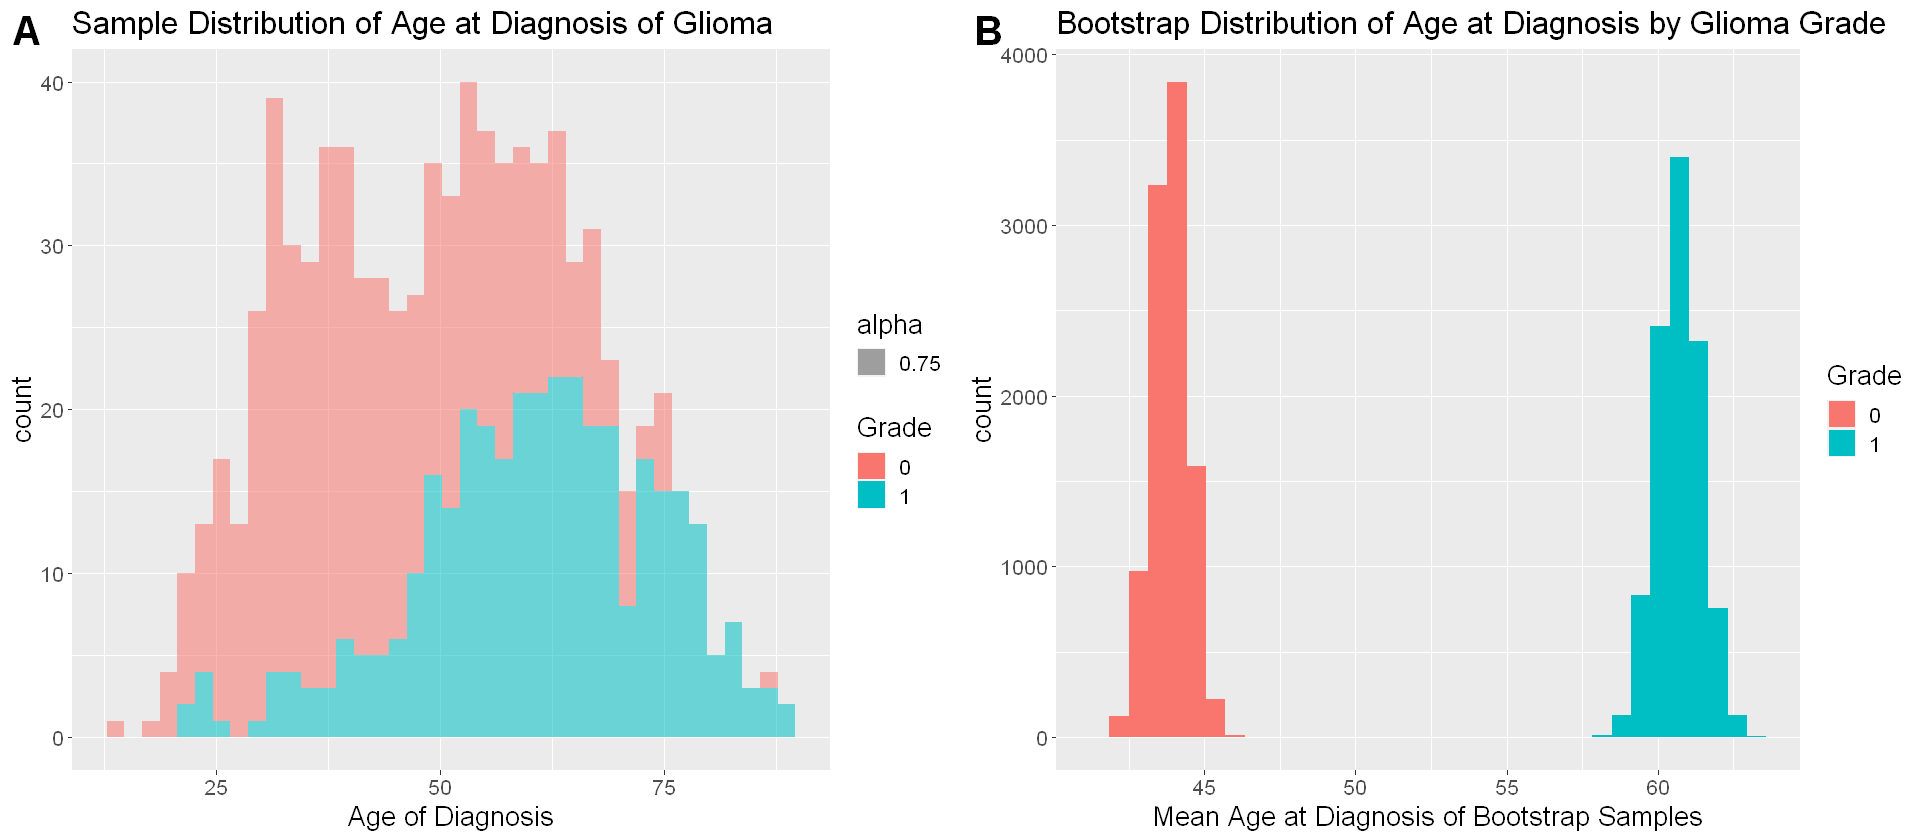

In [7]:
options(repr.plot.width = 16)
plot_grid(age_sample_dist, mean_age_bootstrap_dist, labels = c('A', 'B'), label_size = 24)

**Figure 1A:** The sample distribution of patients ages at the time of glioma diagnosis as encoded in the `Age_at_diagnosis` feature. The histograms are color coded by the glioma grade, where the red histogram indicates low grade glioma, and the cyan histogram displays the distribution of high grade glioma. The purpose of this visualization is to explore whether the sample distribution of patient age at diagnosis reveals anything about their glioma grade. For example, patients diagnosed at a later age may have a higher grade glioma. The distribution has quite a wide range, ranging from about 12 to over 85 years of age. We see majority of the high-grade glioma diagnoses are on the higher end of the distribution, whereas the lower grade gliomas are spread across in what seems to be a bimodal distribution.  
**Figure 1B:** The bootstrap distribution of patients mean age taken from 10,000 bootstrap samples. The mean age of diagnosis for patients with low grade glioma seems to be around 44, and the mean age of diagnosis for high grade glioma patients is around 61. 

#### EGFR Mutation Proportions and Glioma Grade

In [8]:
# Create a bootstrap distribution of mutated EGFR gene proportions 
egfr_virtual_bootstrap_dist <- glioma %>%
    mutate(EGFR = as.factor(EGFR)) %>%
    specify(response = EGFR, success = '1') %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'prop') 

# Create a bootstrap distribution of mutated EGFR gene proportions of the low-grade glioma 
egfr_virtual_samples_0 <- glioma %>%
    filter(Grade == 0) %>%
    mutate(EGFR = as.factor(EGFR)) %>%
    specify(response = EGFR, success = '1') %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'prop') %>%
    cbind(Grade = rep(0, 10000))

# Create a bootstrap distribution of a mutated EGFR gene proportions of the high-grade glioma
egfr_virtual_samples_1 <- glioma %>%
    filter(Grade == 1) %>%
    mutate(EGFR = as.factor(EGFR)) %>%
    specify(response = EGFR, success = '1') %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'prop') %>%
    cbind(Grade = rep(1, 10000))

# Combine the two bootstrap distributions into one dataframe 
egfr_virtual_samples_by_label <- rbind(egfr_virtual_samples_0, egfr_virtual_samples_1) %>%
    mutate(Grade = as.factor(Grade))

In [25]:
# The plot of bootstrap samples by label
plot_by_label <- egfr_virtual_samples_by_label %>%
    ggplot() + 
    geom_histogram(aes(x = stat, fill = Grade), bins = 40) + 
    xlab("Proportion of EGFR Mutations of Bootstrap Samples") + 
    ggtitle("Bootstrap Distribution of EGFR Mutation Proportions by Glioma Grade") + 
    theme(text = element_text(size = 16))

# The plot of bootstrap samples holistically 
plot_entire <- egfr_virtual_bootstrap_dist %>%
    ggplot() + 
    geom_histogram(aes(x = stat), bins = 40) + 
    xlab("Proportion of EGFR Mutations of Bootstrap Samples") + 
    ggtitle("Bootstrap Distribution of EGFR Mutation Proportions by Glioma Grade") + 
    theme(text = element_text(size = 16))

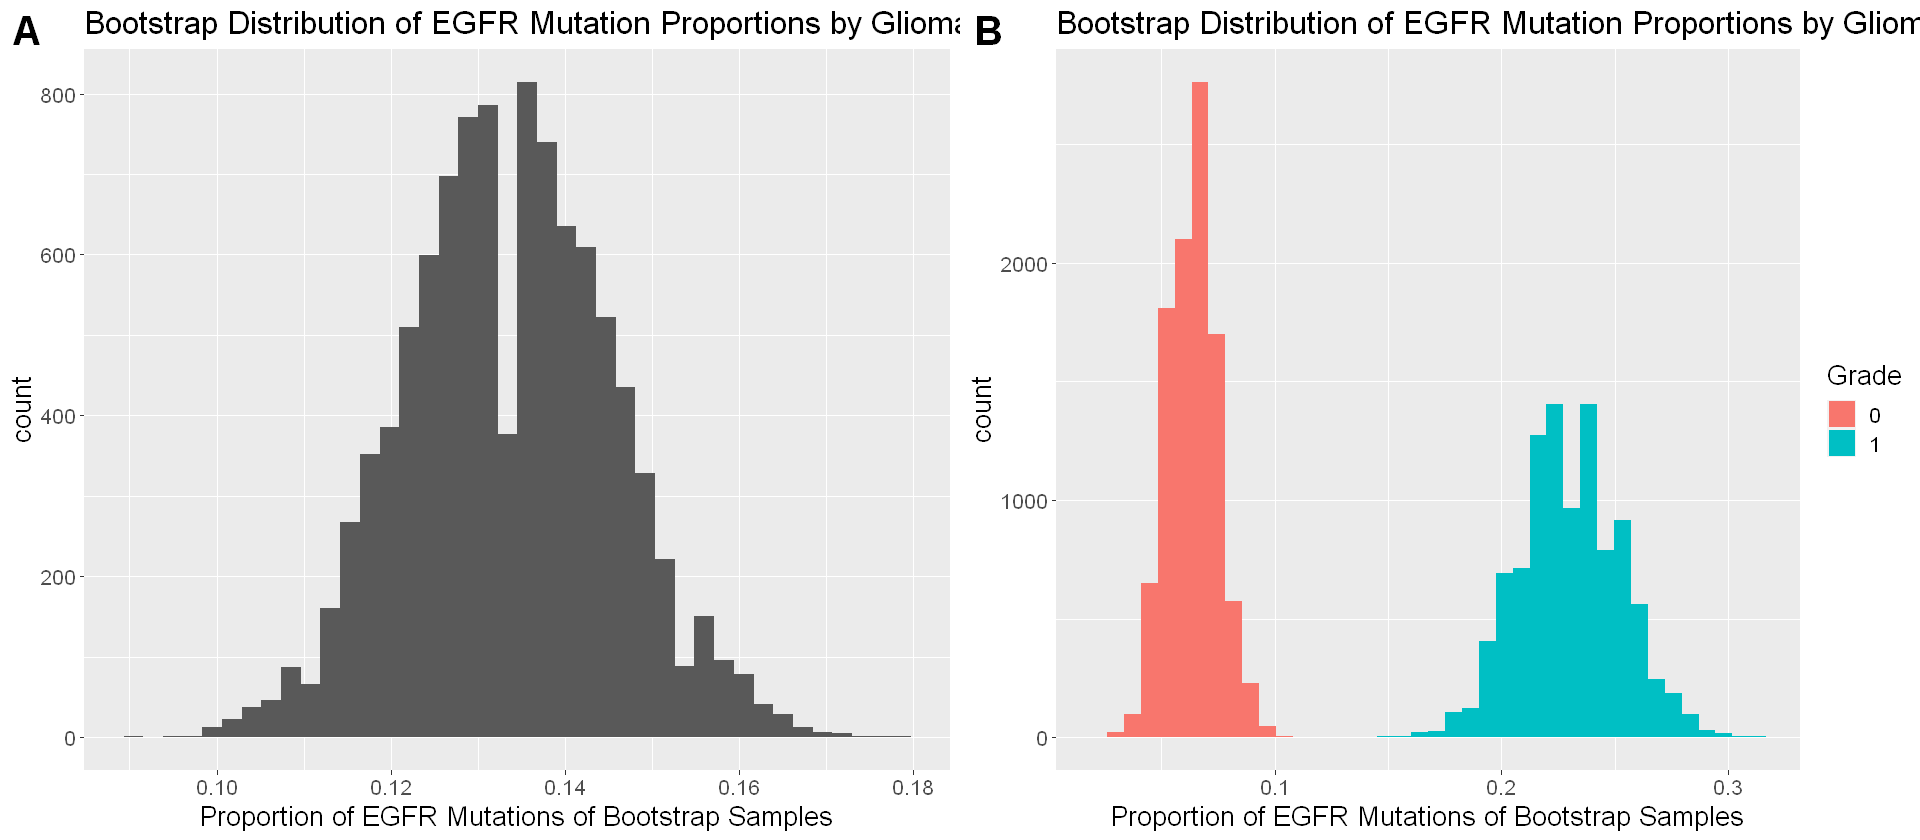

In [26]:
# Plot by grid
plot_grid(plot_entire, plot_by_label, labels = c('A', 'B'), label_size = 24) 

**Figure 2A:** The bootstrap distribution of proportions of EGFR mutations in glioma patients. The mean is around 14%, with approximately 14% of glioma patients have an EGFR gene mutation.  
**Figure 2B:** The bootstrap distribution of proportions of EGFR mutations in low grade vs high grade glioma patients. The mean for low-grade glioma patients is roughly 7%, and the mean for high-grade glioma patients is roughly 24%. This may suggest that EGFR mutations are associated with higher-grade glioma.

### Test Statistic Summary

In [11]:
egfr_bootstrap_mean_0 <- mean(egfr_virtual_samples_0$stat)
egfr_bootstrap_mean_1 <- mean(egfr_virtual_samples_1$stat)
age_bootstrap_mean_0 <- mean(age_virtual_samples_0$stat)
age_bootstrap_mean_1 <- mean(age_virtual_samples_1$stat)

In [12]:
summary.stat.table <- tibble(
    "Low-grade Glioma Patients" = c(egfr_bootstrap_mean_0, age_bootstrap_mean_0),
    "High-grade Glioma Patients" = c(egfr_bootstrap_mean_1, age_bootstrap_mean_1), 
    "Rownames" = c("Proportion EGFR Mutated (p)", "Age of Diagnosis (a)")
    )
summary.stat.table <- summary.stat.table %>%
    column_to_rownames(., var = 'Rownames')
summary.stat.table

,Low-grade Glioma Patients,High-grade Glioma Patients
,<dbl>,<dbl>
Proportion EGFR Mutated (p),0.06379569,0.2301832
Age of Diagnosis (a),43.87205402,60.6950507


At first glance, it seems there is a difference between the low-grade and high-grade glioma patients. To confirm, we will perform hypothesis testing with the following null hypotheses:  
Test one: the proportion of patients with EGFR mutations, $p$:  
* $H_0$: $p_{low-grade} = p_{high-grade}$  
* $H_A$: $p_{low-grade} \neq p_{high-grade}$  

Test two: the age of diagnosis, $a$:
* $H_0$: $\bar x_{low-grade} = \bar x_{high-grade}$
* $H_A$: $\bar x_{low-grade} \neq \bar x_{high-grade}$

## Methods

For our analysis, we will use a bootstrapping approach to do a two-sided hypothesis test for both questions. We will be calculating the differences in means and in proportion to address the two questions. We will perform hypothesis testing by analyzing the quantiles of the simulated distributions. It should be noted that the conditions for ***Central Limit Theorem (CLT)*** are fulfilled: 

1. with 10000 samples of size 839, there will be sufficent sample size for CLT
2. For question 2, $839\times\min(1-0.06366489, 0.06366489)\ge10$ and $839\times\min(1-0.2299338,0.2299338)\ge10$

To be less suceptible to Type 1 and Type 2 error in the hypothesis testing and an $\alpha$ value of 0.05, ensuring 95% confidence in our findings.

Based on preliminary results, the following patterns are visible: 
1. The proportion of GBM patients with EGFR mutation > proportion of LGG patients with EGFR mutation
2. At the time of diagnosis, the mean age of GBM patients > the mean age of LGG patients  

With hypothesis testing, it can be stated that these factors are correlated with glioma grade. The significance of this study is three-fold. First, this may provide an entry-point to genetic and metabolic studies to better understand the pathophysiology of glioma. Second, the tests regarding age at time of diagnosis may contribute to understanding people who may be at higher risk and how the disease develops. Lastly, studying these factors can contribute to screening methods for early detection and better patient prognsis. 

## Hypothesis Testing

### Asymptotic Testing

### Theoretical Testing

In [13]:
alpha <- 0.05

For test one, a difference in proportion test will be used.

t1_summary <- glioma %>%
	group_by(Grade) %>%
 	summarize(grade_n = n(), egfr_n = sum(EGFR), egfr_p = mean(EGFR))

t1_grade_0_summary <- t1_summary[1,]
t1_grade_1_summary <- t1_summary[2,]

t1_pooled_p <- (t1_grade_0_summary$egfr_n + t1_grade_1_summary$egfr_n) / (t1_grade_0_summary$grade_n + t1_grade_1_summary$grade_n)
t1_z <- (t1_grade_0_summary$egfr_p - t1_grade_1_summary$egfr_p) / sqrt(t1_pooled_p * (1 - t1_pooled_p) * (1/t1_grade_0_summary$egfr_n + 1/t1_grade_1_summary$egfr_n))
t1_p_value <- 2 * pnorm(t1_z)


t1_summary
tidy(
	prop.test(
  x = c(t1_grade_0_summary$egfr_n, t1_grade_1_summary$egfr_n),
  n = c(t1_grade_0_summary$grade_n, t1_grade_1_summary$grade_n),
  conf.level = 0.95,
  correct = F
	)
)

print(str_glue("With a z-value of {t1_z}, a p_value of {t1_p_value} was found"))
print(str_glue("This is{if(t1_p_value < alpha) '' else ' not'} more significant than the {alpha} set as the significance level"))

For the second test, a different in means test will be used

In [ ]:
t2_summary <- glioma %>%
	group_by(Grade) %>%
	summarize(grade_n = n(), age_mu = mean(Age_at_diagnosis), age_sd = sd(Age_at_diagnosis))

t2_grade_0_summary <- t2_summary[1, ]
t2_grade_1_summary <- t2_summary[2, ]


t2_diff_mean <- t2_grade_0_summary$age_mu - t2_grade_1_summary$age_mu
t2_var <- t2_grade_0_summary$age_sd^2 / t2_grade_0_summary$grade_n + t2_grade_1_summary$age_sd^2 / t2_grade_1_summary$grade_n

t2_T <- t2_diff_mean / sqrt(t2_var)
t2_df <- t2_var^2 / (t2_grade_0_summary$age_sd^4 / (t2_grade_0_summary$grade_n^2 * (t2_grade_0_summary$grade_n - 1)) + t2_grade_1_summary$age_sd^2 / (t2_grade_1_summary$grade_n^2 * (t2_grade_1_summary$grade_n - 1)))

t2_p <- 2 * pt(t2_T, t2_df, lower.tail = T)

In [ ]:
print(str_glue("With a t-value of {t2_T}, a p_value of {t2_p} was found"))
print(str_glue("This is{if(t2_p < alpha) '' else ' not'} more significant than the {alpha} set as the significance level"))

With a t-value of -18.0081276241434, a p_value of 1.09453670541347e-68 was found
This is more significant than the 0.05 set as the significance level


In [ ]:
t2_grade_0_summary %>%
    summarize(
        lower_ci = qt(0.05, t2_df) * age_sd / sqrt(grade_n) + age_mu,
        upper_ci = qt(0.95, t2_df) * age_sd / sqrt(grade_n) + age_mu
    )

t2_grade_1_summary %>%
    summarize(
        lower_ci = qt(0.05, t2_df) * age_sd / sqrt(grade_n) + age_mu,
        upper_ci = qt(0.95, t2_df) * age_sd / sqrt(grade_n) + age_mu
    )

lower_ci,upper_ci
<dbl>,<dbl>
42.88613,44.86372


lower_ci,upper_ci
<dbl>,<dbl>
59.52619,61.88131


## Discussion

## References

Carrano, Anna, et al. “Sex-Specific Differences in Glioblastoma.” Cells, vol. 10, no. 7, 2021, p. 1783, https://doi.org/10.3390/cells10071783. 

Liu, Haijing, et al. “Spectrum of EGFR Aberrations and Potential Clinical Implications: Insights from Integrative Pan‐cancer Analysis.” Cancer Communications, vol. 40, no. 1, 2020, pp. 43–59, https://doi.org/10.1002/cac2.12005. 

“Release Notice - Canadian Cancer Statistics 2021.” Health Promotion and Chronic Disease Prevention in Canada, vol. 41, no. 11, 2021, pp. 399–399, https://doi.org/10.24095/hpcdp.41.11.09. 

Xu, Hongsheng, et al. “Epidermal Growth Factor Receptor in Glioblastoma.” Oncology Letters, vol. 14, no. 1, 2017, pp. 512–516, https://doi.org/10.3892/ol.2017.6221. 
